<h1 align="center">Optimized Rating Model Part I</h1> 
<h1 align="center">An Exploratory Analysis</h1> 
<h3 align="center">Bradley Droegkamp</h3> 

# Introduction
***
Before grabbing a bite to eat, restaurant patrons often reference user ratings to make decisions on where they go.  The problem is these raw ratings can at times be incomplete or biased, which is a disservice to the restaurant owner and the patron.  Foursquare and other clients that publish user ratings for restaurants have interest in building an optimized rating model to remedy this problem.  As a first step, we would like to have available an exploratory analysis on which variables would be most useful to include in this model.  

The end-result of an optimized rating model is likely a classification model that scales from 0 to 100% (5/5 stars) that closes in on the actual user rating as the number of reviews approaches a certain threshold.  The scope of this project is to define which independent variables to consider in this model.  A/B testing for all potential variables with an incomplete dependent variable could be tedious and incomplete.  Alternatively, we can use K-means clustering to give us more insight into which variables to consider in the final model.  
<br>

# Data
***

We will focus our research on restaurants listed on Foursquare (https://developer.foursquare.com/ ) in the Chicago major metropolitan area.  Along with user ratings, number of ratings, cuisine type, location, and other variables we can obtain from Foursquare, we will reference demographic information about the tracts in which the restaurants are located from the Federal Financial Institutions Examination Council (FFIEC - https://www.ffiec.gov/ ).  A census tract *is a geographic region defined for the purpose of taking a census* (https://en.wikipedia.org/wiki/Census_tract/ ).  FFIEC search results are based on 2015 Census data.

For example, one data point is **Chapati Mediterranean Restaurant** with a user rating of **6.5**/10 given **8** total ratings and **Moderate** affordability according to Foursquare.  The tract this restaurant is located in has a population of **4,888**, an **Upper** income level (definitions for income levels here: https://www.ffiec.gov/census/htm/2015CensusInfoSheet.htm ), and a median household age of **30** according to FFIEC.
<br>

# Methodology
***
### I.  Bring in Foursquare Data

#### Get coordinates for Chicago

In [472]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

address = 'Chicago, IL'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Chicago, IL are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Chicago, IL are 41.8755616, -87.6244212.


#### Bring in initial list of Restaurants in Chicago

In [473]:
import pandas as pd
import numpy as np
import requests
from local_settings import CLIENT_ID, CLIENT_SECRET, VERSION

near = 'Chicago, IL'
query = 'food'
offset = 25  # results are in descending order by rating.  This allows a more diverse dataset by getting every 25th result.
LIMIT = 50  # max of 50 premium calls.  This is limiting.

restaurants_list=[]

# create the API request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&section={}&offset={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    near, 
    query,
    offset,
    LIMIT)

# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']

# return information for each restaurant
restaurants_list.append([(
    v['venue']['name'], 
    v['venue']['id'],
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['location']['address'], 
    v['venue']['location']['city'], 
    v['venue']['location']['state'], 
    v['venue']['categories'][0]['name']) for v in results])

restaurants = pd.DataFrame([item for restaurant_list in restaurants_list for item in restaurant_list])
restaurants.columns = ['Name', 
                       'ID',
                       'Latitude', 
                       'Longitude', 
                       'Address',
                       'City',
                       'State',
                       'Category']

print(restaurants.shape)
restaurants.head()

(50, 8)


,Name,ID,Latitude,Longitude,Address,City,State,Category
0,3 Arts Club Cafe,56199b9f498e26fd033cbe10,41.905800,-87.630470,1300 N Dearborn St,Chicago,IL,Café
1,Alinea,4686299bf964a5203a481fe3,41.913470,-87.648338,1723 N Halsted St,Chicago,IL,Molecular Gastronomy Restaurant
2,Coalfire,4a3d97f7f964a5207ea21fe3,41.891000,-87.659751,1321 W Grand Ave,Chicago,IL,Pizza Place
3,Superdawg Drive-In,42cc7080f964a520ed251fe3,41.996737,-87.787044,6363 N Milwaukee Ave,Chicago,IL,Hot Dog Joint
4,RPM Italian,4f1322f3e4b0725fed919ce7,41.890815,-87.629755,52 W Illinois St,Chicago,IL,Italian Restaurant


#### Let's take a look at these restaurants on a map

In [474]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, category in zip(restaurants['Latitude'], restaurants['Longitude'], restaurants['Name'], restaurants['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

#### Add ratings and price details (note Foursquare max daily quota = 50)

In [475]:
# define function that grabs restaurant details by ID
def getVenueDetail(id):
    '''
    Returns Foursquare Venue Name, Rating, and Pricing by ID
    '''
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)

    # make the GET request
    results = requests.get(url).json()['response']
    try:
        return ([results['venue']['name'], results['venue']['rating'], results['venue']['price']['message']])
    except:
        print(requests.get(url).json()['meta']['errorType'])
        return (null)

for id in restaurants['ID']:
    try:
        detail_list = getVenueDetail(id)
        restaurants.loc[restaurants.ID == id, 'Rating'] = detail_list[1]
        restaurants.loc[restaurants.ID == id, 'Pricing'] = detail_list[2]
    except:
        print('Error')
        break;

print(restaurants.shape)
restaurants.head()

quota_exceeded
Error
(50, 8)


,Name,ID,Latitude,Longitude,Address,City,State,Category
0,3 Arts Club Cafe,56199b9f498e26fd033cbe10,41.905800,-87.630470,1300 N Dearborn St,Chicago,IL,Café
1,Alinea,4686299bf964a5203a481fe3,41.913470,-87.648338,1723 N Halsted St,Chicago,IL,Molecular Gastronomy Restaurant
2,Coalfire,4a3d97f7f964a5207ea21fe3,41.891000,-87.659751,1321 W Grand Ave,Chicago,IL,Pizza Place
3,Superdawg Drive-In,42cc7080f964a520ed251fe3,41.996737,-87.787044,6363 N Milwaukee Ave,Chicago,IL,Hot Dog Joint
4,RPM Italian,4f1322f3e4b0725fed919ce7,41.890815,-87.629755,52 W Illinois St,Chicago,IL,Italian Restaurant


### II.  Bring in Census Data from Federal Financial Institutions Examination Council
#### FFIEC - https://www.ffiec.gov/

In [476]:
import requests
import json

def getCensusData(address):
    '''
    Returns FFIEC 2015 Census est. income, income indicator, population, and median unit age by Tract of address specified
    '''   
    
    headers = {'content-type': 'application/json; charset=utf-8'}

    # create the API geocode request URL and payload
    geocode_url = 'https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetGeocodeData'
    geocode_payload = {'sSingleLine': address, 'iCensusYear': "2018"}

    # make the POST request
    geocode_r = requests.post(geocode_url, headers=headers, data=json.dumps(geocode_payload))
    geocode_json = json.loads(geocode_r.text)

    # now create the API censusdata request URL and payload
    census_url = 'https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetCensusData'
    census_payload = {'sMSACode': geocode_json['d']['sMSACode'], 'sStateCode': geocode_json['d']['sStateCode'], 
                      'sCountyCode': geocode_json['d']['sCountyCode'], 'sTractCode': geocode_json['d']['sTractCode'], 
                      'iCensusYear': "2018"}
    census_r = requests.post(census_url, headers=headers, data=json.dumps(census_payload))
    census_json = json.loads(census_r.text)
    
    return ([census_json['d']['sIncome_Indicator'], 
             census_json['d']['sEst_Income'], 
             census_json['d']['sPopulation'],
             census_json['d']['sMedian_unit_age']])


for address, city, state in zip(restaurants['Address'], restaurants['City'], restaurants['State']):
    detail_list = getCensusData(address + ', ' + city + ', ' + state)
    restaurants.loc[restaurants.Address == address, 'Income_Indicator'] = detail_list[0]
    restaurants.loc[restaurants.Address == address, 'Est_Income'] = detail_list[1]
    restaurants.loc[restaurants.Address == address, 'Population'] = detail_list[2]
    restaurants.loc[restaurants.Address == address, 'Median_Unit_Age'] = detail_list[3]

# clean up dataframe
restaurants.Est_Income = pd.to_numeric(restaurants.Est_Income)
restaurants.Population = pd.to_numeric(restaurants.Population)
restaurants.Median_Unit_Age = pd.to_numeric(restaurants.Median_Unit_Age)
# be sure to add back rating and pricing here
restaurants = restaurants[['Name', 'Latitude', 'Longitude', 'Category', 'Income_Indicator', 'Est_Income', 'Population', 'Median_Unit_Age']]

restaurants.to_csv('restaurants.csv')

print(restaurants.shape)
restaurants.head()

(50, 8)


,Name,Latitude,Longitude,Category,Income_Indicator,Est_Income,Population,Median_Unit_Age
0,3 Arts Club Cafe,41.905800,-87.630470,Café,Upper,176171,3664,48
1,Alinea,41.913470,-87.648338,Molecular Gastronomy Restaurant,Upper,174672,2714,39
2,Coalfire,41.891000,-87.659751,Pizza Place,Middle,89107,2919,76
3,Superdawg Drive-In,41.996737,-87.787044,Hot Dog Joint,Middle,86800,5285,62
4,RPM Italian,41.890815,-87.629755,Italian Restaurant,Upper,120024,3234,16


### III.  Explore Data

In [477]:
restaurants.describe(include='all').round(2)

,Name,Latitude,Longitude,Category,Income_Indicator,Est_Income,Population,Median_Unit_Age
count,50,50.00,50.00,50,50,50.00,50.00,50.00
unique,50,NaN,NaN,32,4,NaN,NaN,NaN
top,Owen & Engine,NaN,NaN,New American Restaurant,Upper,NaN,NaN,NaN
freq,1,NaN,NaN,4,38,NaN,NaN,NaN
mean,NaN,41.91,-87.66,NaN,NaN,134677.12,3884.22,47.22
std,NaN,0.04,0.03,NaN,NaN,52382.03,1532.73,25.06
min,NaN,41.83,-87.79,NaN,NaN,12896.00,1440.00,11.00
25%,NaN,41.89,-87.68,NaN,NaN,111983.75,2895.00,20.50
50%,NaN,41.90,-87.65,NaN,NaN,129693.50,3234.00,50.00
75%,NaN,41.93,-87.63,NaN,NaN,180392.00,5161.50,76.00


AttributeError: 'DataFrame' object has no attribute 'Income_Indicator'

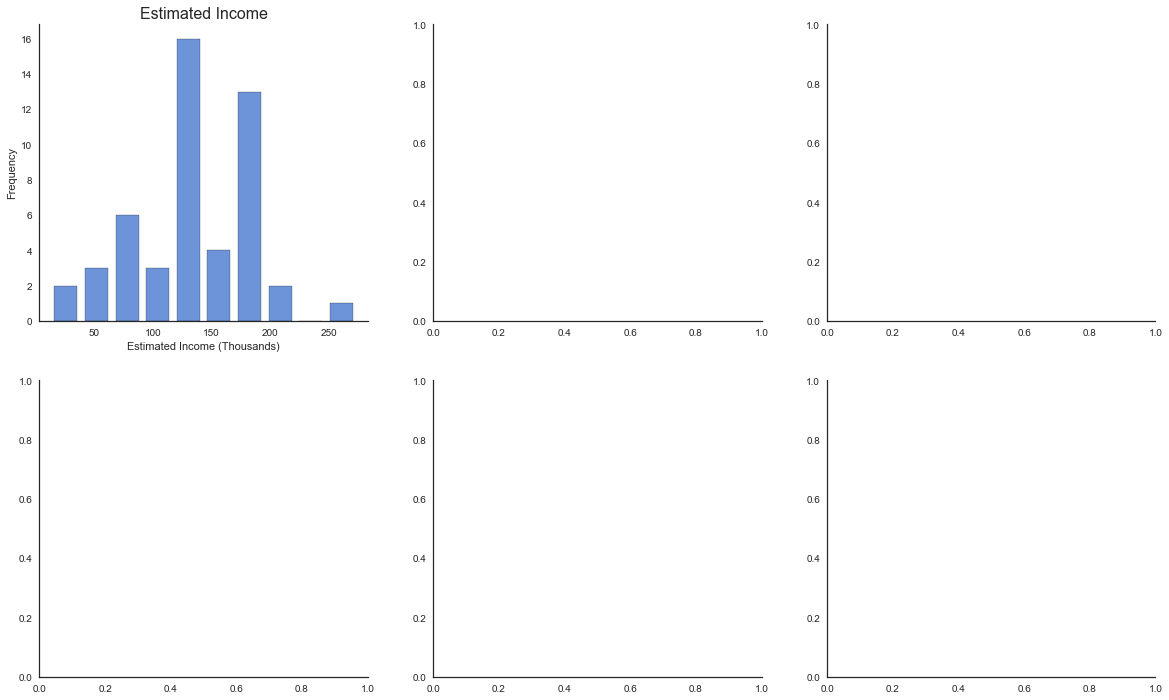

In [496]:
# graph est income, income indicator, population, median unit age, rating, and pricing
# histograms, bar plots for categorical?
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

fig, ax = plt.subplots(2, 3, figsize=(20, 12))
sns.despine()
sns.distplot(restaurants.Est_Income/1000, kde=False, bins=10, 
             hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':0.8}, ax=ax[0, 0])
ax[0, 0].set_xlabel("Estimated Income (Thousands)")
ax[0, 0].set_ylabel("Frequency")
ax[0, 0].set_title("Estimated Income", fontsize=16)
sns.countplot(restaurants.Income_Indicator, order=['Low', 'Moderate', 'Middle', 'Upper'] , ax=ax[0, 1])
ax[0, 1].set_xlabel("Income Indicator")
ax[0, 1].set_ylabel("Frequency")
ax[0, 1].set_title("Income Indicator*", fontsize=16)
sns.distplot(restaurants.Median_Unit_Age, kde=False, bins=10, 
             hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':0.8}, ax=ax[0, 2])
ax[0, 2].set_xlabel("Median Unit Age (yrs)")
ax[0, 2].set_ylabel("Frequency")
ax[0, 2].set_title("Median Unit Age (yrs)", fontsize=16)
sns.distplot(restaurants.Population, kde=False, bins=10, 
             hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':0.8}, ax=ax[1, 0])
ax[1, 0].set_xlabel("Population")
ax[1, 0].set_ylabel("Frequency")
ax[1, 0].set_title("Population", fontsize=16)
ax[1, 0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
sns.countplot(restaurants.Pricing, order=['Low', 'Middle', 'Moderate', 'Upper'] , ax=ax[1, 1])
ax[1, 1].set_xlabel("Pricing")
ax[1, 1].set_ylabel("Frequency")
ax[1, 1].set_title("Pricing Metric", fontsize=16)
sns.distplot(restaurants.Rating, kde=False, bins=10, 
             hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':0.8}, ax=ax[1, 2])
ax[1, 2].set_xlabel("Rating")
ax[1, 2].set_ylabel("Frequency")
ax[1, 2].set_title("Rating", fontsize=16)

\**Income Indicator is defined as:*
>**Tract Income Level** - *This corresponds to tract classifications as defined by the HMDA and CRA regulations. This field is based on the Tract Median Family Income %:
If the Median Family Income % is < 50% then the Income Level is Low.
If the Median Family Income % is >= 50% and < 80% then the Income Level is Moderate.
If the Median Family Income % is >= 80% and < 120% then the Income Level is Middle.
If the Median Family Income % is > =120% then the Income Level is Upper.*
<br>https://www.ffiec.gov/census/htm/2015CensusInfoSheet.htm

#### Some Observations:
- The majority of our sample of restaurants reside in **Upper** Income Bracket areas.
- We can remove **Income Indicator** since Estimated Income provides a more granular detail.
- **Median Unit Age** gives us an idea of how mature the area is.  It appears most areas are either newly rebuilt or historic, with less in-between.
- **Ratings** from Foursquare are sorted by descending order.


In [479]:
# drop Income Indicator column
restaurants = restaurants.drop(['Income_Indicator'], axis=1)
restaurants.head()

,Name,Latitude,Longitude,Category,Est_Income,Population,Median_Unit_Age
0,3 Arts Club Cafe,41.905800,-87.630470,Café,176171,3664,48
1,Alinea,41.913470,-87.648338,Molecular Gastronomy Restaurant,174672,2714,39
2,Coalfire,41.891000,-87.659751,Pizza Place,89107,2919,76
3,Superdawg Drive-In,41.996737,-87.787044,Hot Dog Joint,86800,5285,62
4,RPM Italian,41.890815,-87.629755,Italian Restaurant,120024,3234,16


#### Let's take a closer look at the types of Restaurants in the dataset

In [480]:
print('There are {} unique restaurant categories.'.format(len(restaurants.Category.unique())))

There are 32 unique restaurant categories.


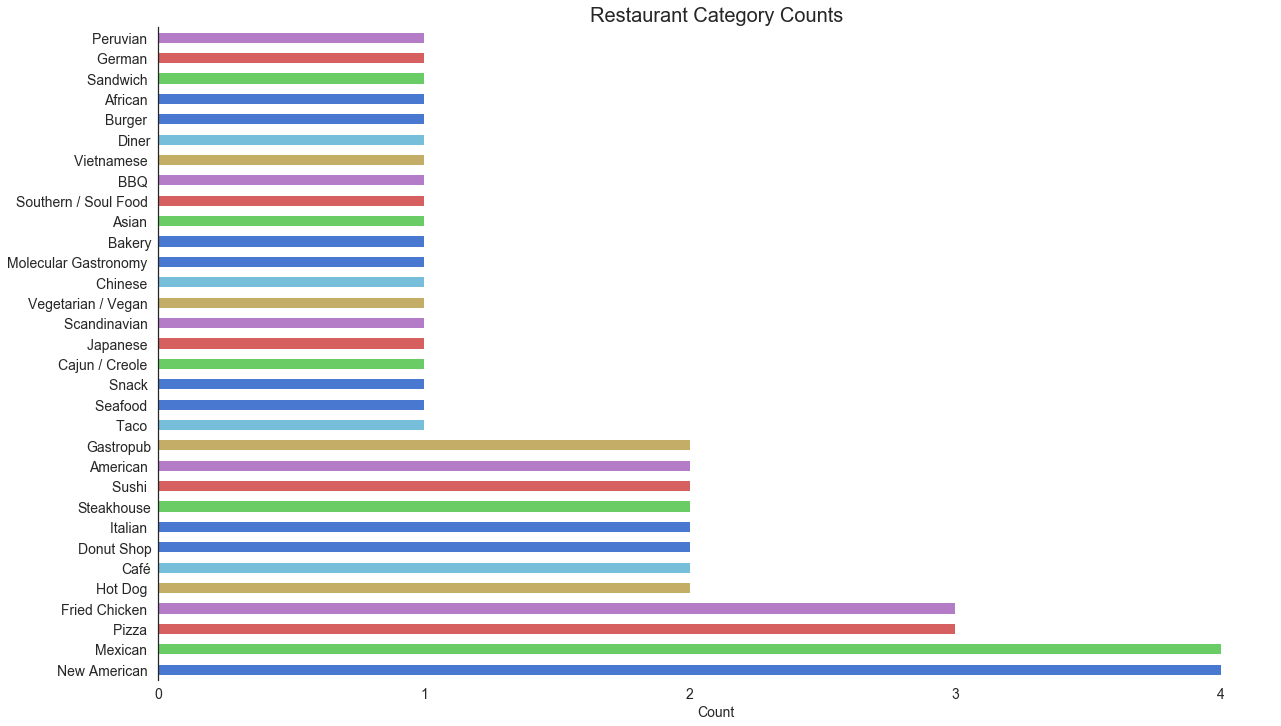

In [481]:
# first clean up Category names by trimming unnecessary descriptors
descriptors = ['Restaurant', 'Place', 'Joint']
for category in restaurants.Category:
    if any(desc in category for desc in descriptors):
        new_cat = category
        for desc in descriptors:
            new_cat = new_cat.replace(desc, '')
        restaurants.loc[restaurants.Category == category, 'Category'] = new_cat

ax = restaurants.Category.value_counts().plot(kind='barh', figsize=(20, 12), fontsize = 14)
ax.set_title('Restaurant Category Counts', fontsize=20)
ax.set_xlabel("Count", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

New American, Mexican, Pizza, and Fried Chicken are most common.  There doesn't appear to be any obvious overlaps in categories that needs to be addressed.

### IV.  K-means Clustering

#### First encode categorical data for analysis

In [482]:
# one hot encoding
onehot = pd.get_dummies(restaurants[['Category']], prefix="", prefix_sep="")

# create dataset for cluster analysis
# add pricing rating here
cluster_data = restaurants[['Est_Income', 'Population', 'Median_Unit_Age']].join(onehot)

print(cluster_data.shape)
cluster_data.head()

(50, 35)


,Est_Income,Population,Median_Unit_Age,African,American,Asian,BBQ,Bakery,Burger,Café,...,Sandwich,Scandinavian,Seafood,Snack,Southern / Soul Food,Steakhouse,Sushi,Taco,Vegetarian / Vegan,Vietnamese
0,176171,3664,48,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,174672,2714,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,89107,2919,76,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,86800,5285,62,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,120024,3234,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### K-means Analysis

In [489]:
from sklearn.cluster import KMeans

kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_data)

# merge cluster labels with original dataframe
restaurant_clusters = restaurants[:]
restaurant_clusters.insert(0, 'Cluster_Labels', kmeans.labels_)

restaurant_clusters.head()

,Cluster_Labels,Name,Latitude,Longitude,Category,Est_Income,Population,Median_Unit_Age
0,0,3 Arts Club Cafe,41.905800,-87.630470,Café,176171,3664,48
1,0,Alinea,41.913470,-87.648338,Molecular Gastronomy,174672,2714,39
2,1,Coalfire,41.891000,-87.659751,Pizza,89107,2919,76
3,1,Superdawg Drive-In,41.996737,-87.787044,Hot Dog,86800,5285,62
4,2,RPM Italian,41.890815,-87.629755,Italian,120024,3234,16


#### Map restaurants with Cluster Detail

In [490]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
rainbow = ['red', 'blue', 'purple', 'green', 'black', 'white', 'yellow']

# add markers to the map
markers_colors = []
for lat, lon, name, cat, cluster in zip(restaurant_clusters['Latitude'], restaurant_clusters['Longitude'], 
                                        restaurant_clusters['Name'], restaurant_clusters['Category'],
                                        restaurant_clusters['Cluster_Labels']):
    label = folium.Popup(name + ' - ' + cat + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

# Results
***
<br>

### Compare All Numerical Fields by Cluster

In [519]:
# don't need lat and long anymore
restaurant_results = restaurant_clusters.drop(['Latitude', 'Longitude'], axis=1)

print('Cluster Counts:')
print(restaurant_results.groupby('Cluster_Labels')['Name'].count().reset_index(drop=True))
print('\n\nAverages:')
restaurant_results.groupby('Cluster_Labels').mean().round(0)

Cluster Counts:
0    19
1    12
2    19
Name: Name, dtype: int64


Averages:


,Est_Income,Population,Median_Unit_Age
Cluster_Labels,,,
0,187459.0,3901.0,36.0
1,63958.0,3831.0,71.0
2,126560.0,3901.0,43.0


#### Income levels in each area are significantly different (more here, along with charts below?)

In [492]:
# charts here

### Top Restaurant Categories by Cluster
#### more observations of charts below

In [493]:
# restaurants.groupby('Cluster_Labels').Category.agg(lambda x: x.value_counts().index[0:3])
restaurant_results.groupby('Cluster_Labels').Category.value_counts() #how to plot?
# chart this

Cluster_Labels  Category             
0               New American             3
                Café                     2
                Steakhouse               2
                American                 1
                Burger                   1
                Chinese                  1
                Fried Chicken            1
                Gastropub                1
                Italian                  1
                Japanese                 1
                Molecular Gastronomy     1
                Pizza                    1
                Snack                    1
                Sushi                    1
                Vietnamese               1
1               Fried Chicken            2
                Mexican                  2
                Pizza                    2
                African                  1
                Hot Dog                  1
                New American             1
                Peruvian                 1
                

# Discussion
***
Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
<br>

# Conclusion
***
Conclusion section where you conclude the report.
<br>